In [1]:
from functools import partial

import numpy as np

np.set_printoptions(precision=3, suppress=True)

import matplotlib.pyplot as plt

import jax
from jax.flatten_util import ravel_pytree
from jax import numpy as jnp, random as jr, value_and_grad, tree_util

import optax

from env import Env
from svae.inference import make_gradfun
from svae.utils import split_into_batches, flat
from network import init_mlp, identity, make_loglike
from hmm import run_inference, init_pgm_param, rollout, onehot_sample, gumbel_softmax

In [2]:
key = jr.PRNGKey(123)
batch_dim = 64
num_epochs, num_samples, num_steps = 2000, 64 * 10, 8

env = Env()

data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_samples, num_steps)
data = data.reshape(num_samples, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def test(params, data, actions, env, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params

    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx + 1, :]
    test_actions = actions[idx : idx + 1, :]

    node_potentials = encoder(encoder_params, test_data)
    samples, _, _, _ = run_inference(infer_key, pgm_prior_params, pgm_params, node_potentials, 1, test_actions)
    decoded = decoder(decoder_params, samples)

    test_data_0, test_actions = test_data[0, 0, :], test_actions[0, :]
    node_potential_0 = encoder(encoder_params, test_data_0)
    logits = rollout(pgm_params, node_potential_0, test_actions)
    # for i in range(logits.shape[0]):
    #     print(jax.nn.softmax(logits[i]))
    sample_key, key = jr.split(key)
    samples = onehot_sample(logits, sample_key)
    decoded_rollout = decoder(decoder_params, samples)

    env.plot_sample(test_data.reshape(-1, 10, 10), test_actions)
    env.plot_sample(decoded.reshape(-1, 10, 10))
    env.plot_sample(decoded_rollout.reshape(-1, 10, 10))

    probs = pgm_params[1] / jnp.sum(pgm_params[1], axis=-1, keepdims=True)
    fig, axs = plt.subplots(1, 4)
    for i in range(4):
        axs[i].imshow(probs[i])
        axs[i].axis("off")
    plt.show()

epoch 0: 554.94


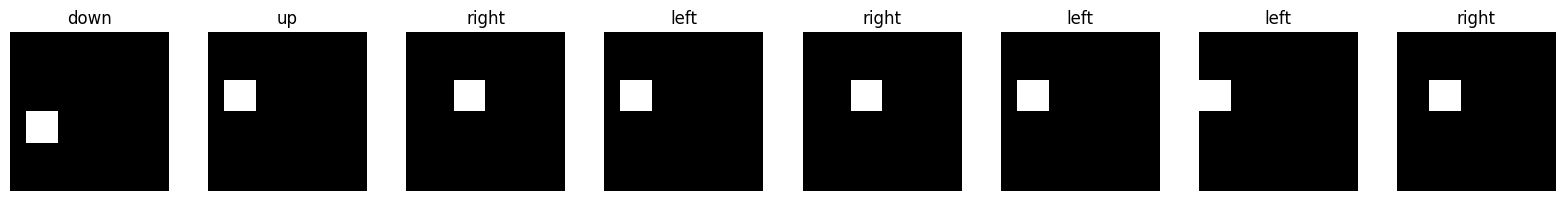

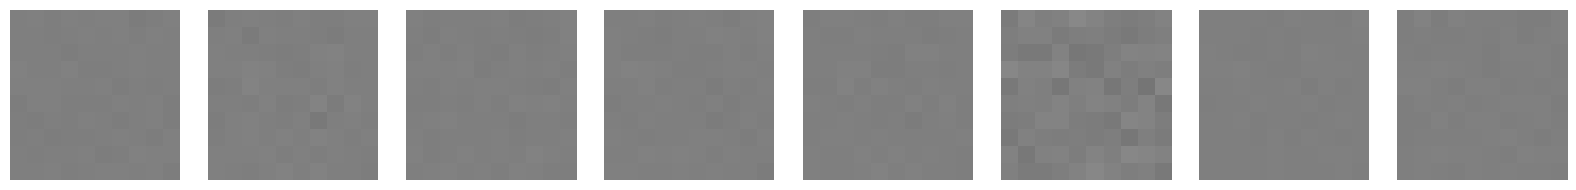

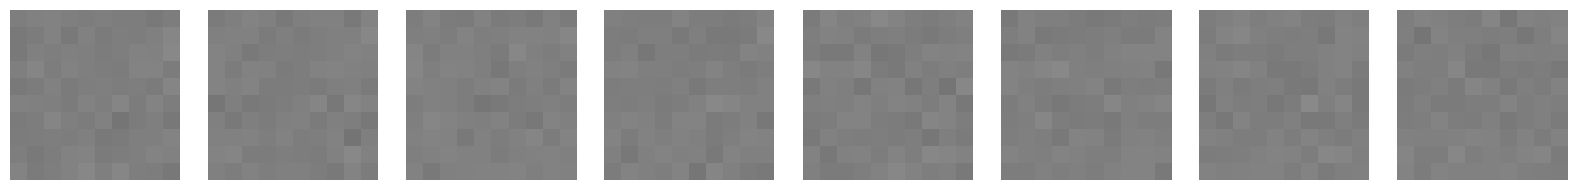

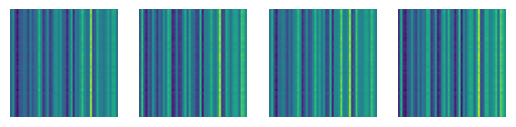

epoch 100: 119.34


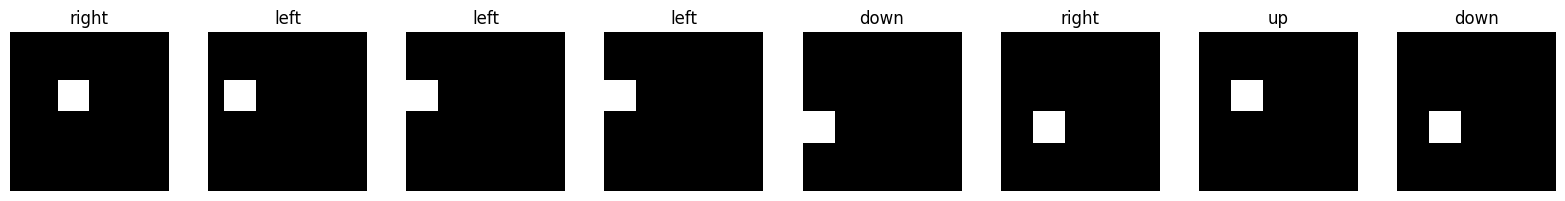

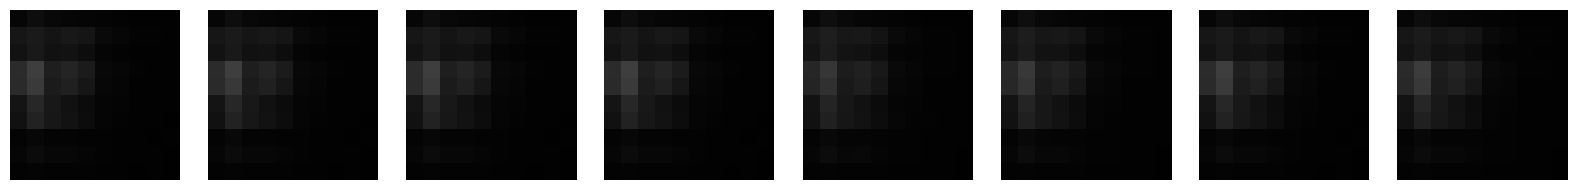

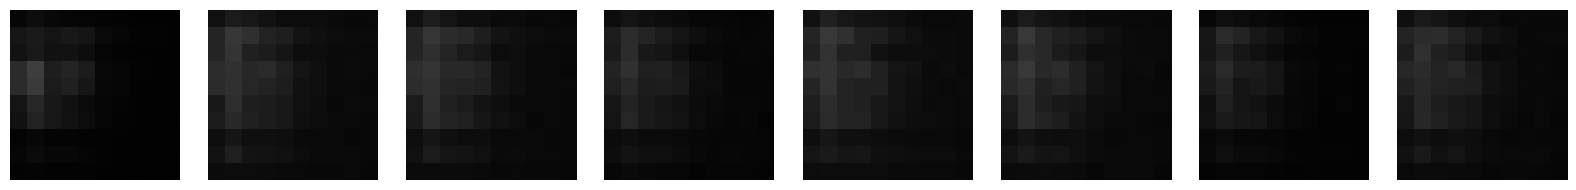

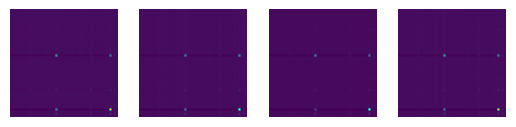

epoch 200: 103.37


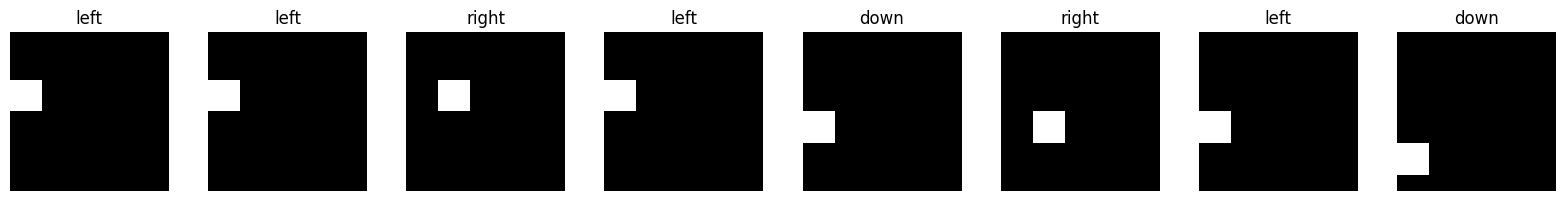

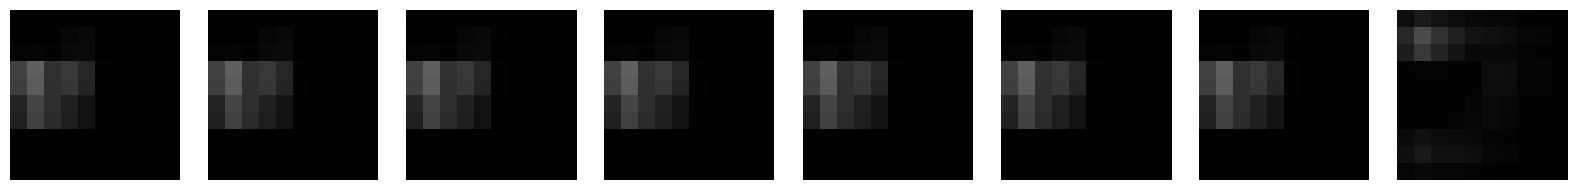

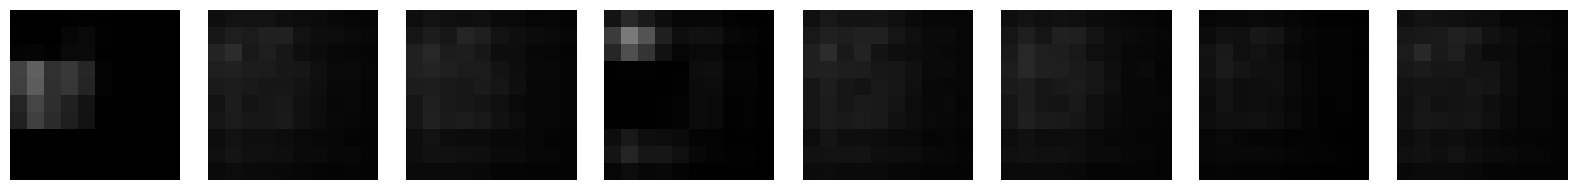

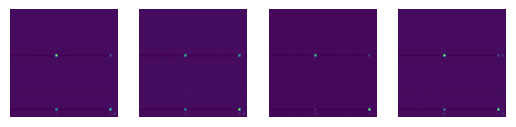

In [4]:
num_epochs = 5000
A, K, D = 4, 50, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, A, alpha=1.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, A, alpha=1.0)
params = pgm_params, decoder_params, encoder_params
nn_params = (decoder_params, encoder_params)

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_samples, num_batches, 1e4)

optim = optax.adam(learning_rate=1e-3)
# opt_state = optim.init(params)
opt_state = optim.init(nn_params)

for epoch in range(num_epochs):
    grads, elbo = gradfun(params, get_batch(epoch), get_action_batch(epoch))

    # updates, opt_state = optim.update(grads, opt_state, params)
    # params = optax.apply_updates(params, updates)

    updates, opt_state = optim.update((grads[1], grads[2]), opt_state, nn_params)
    nn_params = optax.apply_updates(nn_params, updates)

    # sgd step
    pgm_params_0 = pgm_params[0] - 1e-4 * grads[0][0]
    pgm_params_1 = pgm_params[1] - 1e-4 * grads[0][1]

    pgm_params = (pgm_params_0, pgm_params_1)
    params = (pgm_params, nn_params[0], nn_params[1])

    if epoch % 100 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test(params, data, actions, env, key)